## Import

In [12]:
import tensorflow_hub as hub
import tensorflow as tf
import numpy as np
import math
from PIL import ImageDraw, ImageColor, Image, ImageFont, ImageOps
import matplotlib.pyplot as plt


MIN_SCORE = .1
NUMBER_OF_INTERVALS = 5

## Load the Model

In [13]:
module_handle = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1"
model = hub.load(module_handle)
detector = model.signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


## Image

In [14]:
def load_img(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image

def display_image(image, imageSize):
    print(imageSize)
    
    interval = imageSize[0] // NUMBER_OF_INTERVALS
    major_ticks = np.arange(0, imageSize[0], interval)
    fig, ax = plt.subplots()
    ax.set_xticks(major_ticks)
    plt.grid(which='major')
    plt.imshow(image)

## Draw

In [ ]:
def draw_boxes(image, indices, boxes, classes, scores, min_score = MIN_SCORE):
    colors = list(ImageColor.colormap.values())

    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
    except IOError:
        print("Font not found, using default font.")
        font = ImageFont.load_default()
    
    size = 0
    for index in indices:
        if scores[index] > min_score:
            color = colors[hash(classes[index]) % len(colors)]
            image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
            size = image_pil.size

            draw_box_on_image(image_pil, boxes[index], color, font, display_str_list=[classes[index]])
            np.copyto(image, np.array(image_pil))
        
    return image, size

def draw_box_on_image(image, box, color, font, thickness=4, display_str_list=()):
    draw = ImageDraw.Draw(image)
    width, height = image.size
    (left, right, bottom, top) = (box[1] * width, box[3] * width, box[0] * height, box[2] * height)
    
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)], width=thickness, fill=color)

    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)
    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = top + total_display_str_height

    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                        (left + text_width, text_bottom)],
                       fill=color)
        draw.text((left + margin, text_bottom - text_height - margin),
                  display_str,
                  fill="black",
                  font=font)
        text_bottom -= text_height - 2 * margin

        

## Object Locator

(290, 290)
[(0.7336089015007019, 0.7650267481803894)]
[4]
(290, 290)
[(0.7683783173561096, 0.7629258632659912)]
[4]


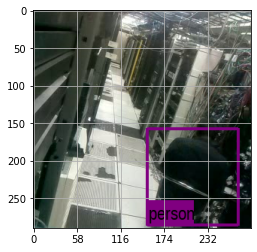

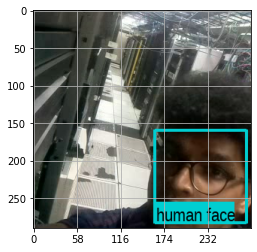

In [24]:
imageSize = (1024, 683)
def run_detector(detector, path, item):
    image = load_img(path)
    converted_image = tf.image.convert_image_dtype(image, tf.float32)[tf.newaxis, ...]
    result = detector(converted_image)
    result = {key: value.numpy() for key, value in result.items()}

    classes = np.array([value.decode("ascii").lower() for value in result['detection_class_entities']])
    boxes = result['detection_boxes']
    scores = result['detection_scores']
    indices = np.where(classes == item.lower())[0]

    image_with_boxes, imageSize = draw_boxes(image.numpy(), indices, boxes, classes, scores)
    if imageSize == 0:
        imageSize = (1024, 683)
    #print(classes)
    display_image(image_with_boxes, imageSize)
    
    centroids = find_centroid(indices, boxes, scores)
    print(centroids)
    print(find_region(centroids, imageSize))
    
    
def find_centroid(indices, locations, scores, min_score = MIN_SCORE):
    centroids = []
    for index in indices:
        if scores[index] >= min_score:
            ymin, xmin, ymax, xmax = tuple(locations[index])
            centroids.append(((xmin+xmax)/2, (ymin+ymax)/2))
    return centroids

def find_region(centroids, imageSize):
    x = imageSize[0] // NUMBER_OF_INTERVALS
    regions = []
    for point in centroids:
        regions.append(math.ceil((point[0] * imageSize[0] )/ x))
    return regions

run_detector(detector, "/home/white_wolf/Downloads/Code/Images/data/frame28.jpg", "person")
run_detector(detector, "/home/white_wolf/Downloads/Code/Images/data/frame16.jpg", "human face")


# return the result {id: link of the vid, result: 'unknown person found near rack 3'}